/home/vallee/Documents/deep_sort_pytorch/deep_sort/deep/feature_extractor.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_locati

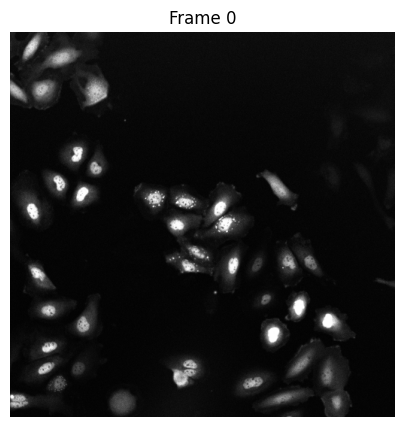

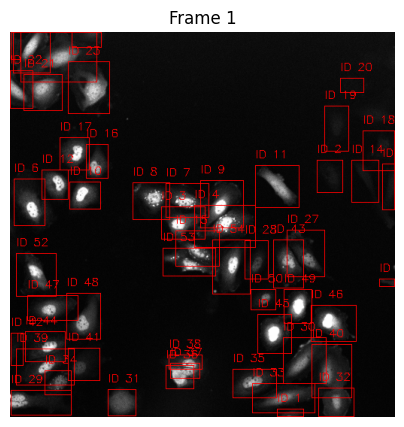

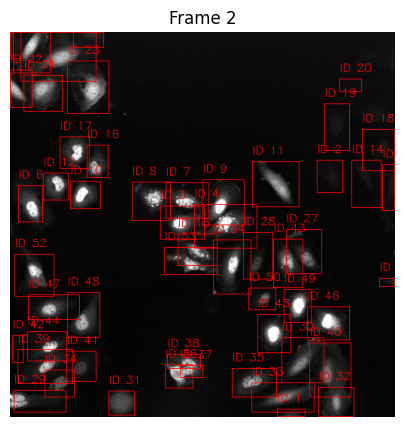

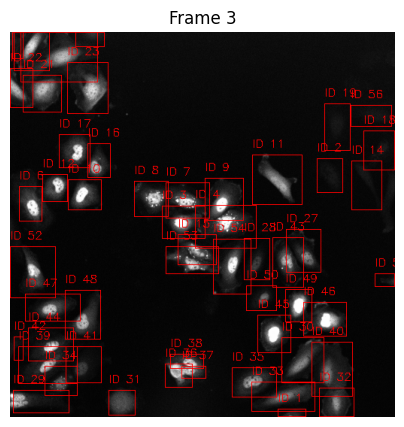

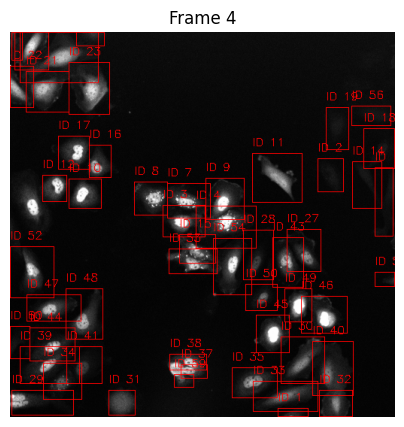

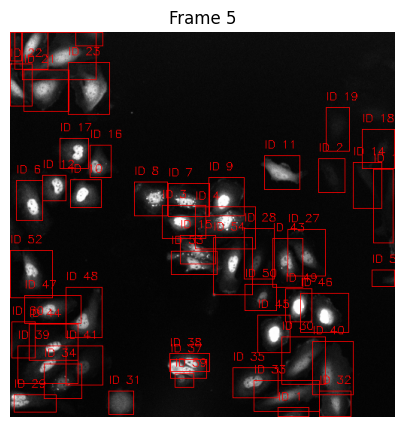

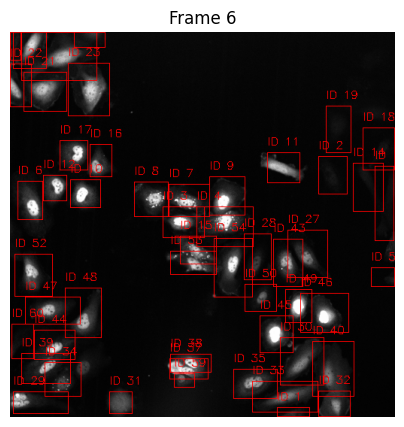

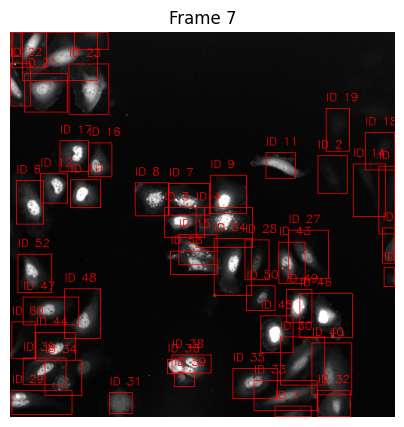

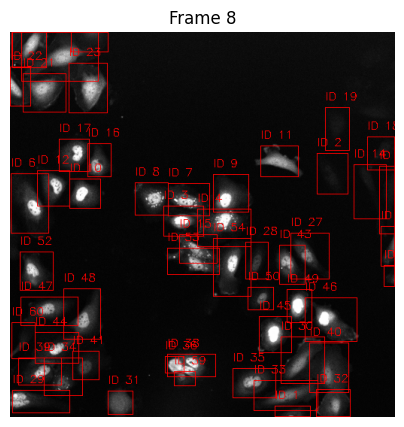

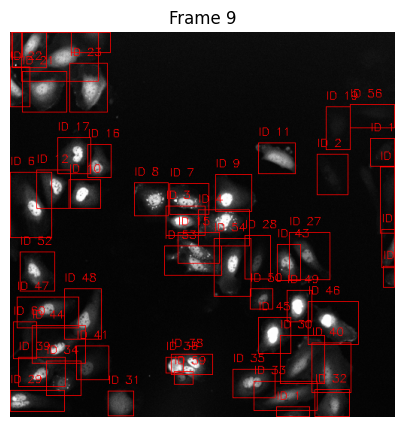

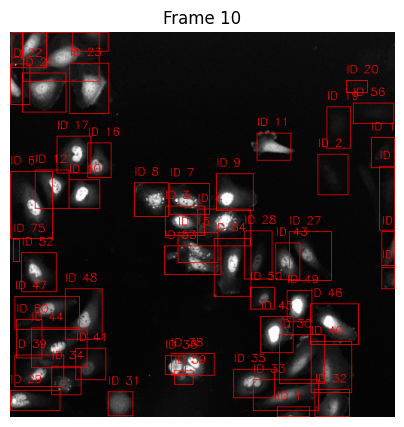

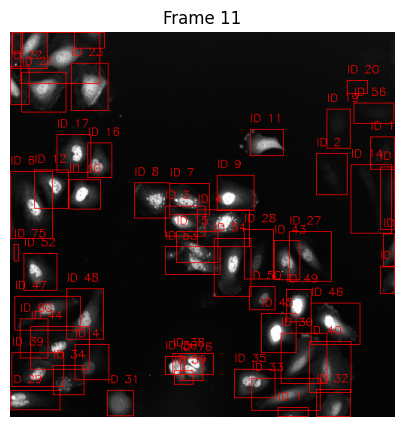

In [ ]:
import numpy as np
import cv2
import os
import tifffile
import matplotlib.pyplot as plt
import torch

from deep_sort.deep_sort import DeepSort

torch.cuda.empty_cache()

# === Charger les masks .tif ===

masks_dir = "/home/vallee/Documents/resultat/CTC_dataset_2/mask_raw"

mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith(".tif")])
masks_init = [tifffile.imread(os.path.join(masks_dir, f)).astype(np.uint8) for f in mask_files]

# === Charger les images .tif ===

im_dir = "/home/vallee/Documents/Data/Fluo-C2DL-Huh7/Training/02"

im_files = sorted([f for f in os.listdir(im_dir) if f.endswith(".tif")])
images = [tifffile.imread(os.path.join(im_dir, f)).astype(np.uint8) for f in im_files]

images_resized = []
for img in images:
    img_resized = cv2.resize(img, (512, 512), interpolation=cv2.INTER_LINEAR)
    images_resized.append(img_resized)

masks = []
for mask in masks_init:
    mask_resized = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)
    masks.append(mask_resized)

# === Initialiser DeepSORT ===

deepsort = DeepSort(
    model_path='deep_sort/deep/checkpoint/ckpt.t7',
    max_dist=0.5,
    min_confidence=0.5,
    nms_max_overlap=0.6,
    max_iou_distance=0.7,
    max_age=30,
    n_init=2,
    nn_budget=100,
    use_cuda=True
)

# === Traiter toutes les frames ===

for frame_idx, mask in enumerate(masks):

    vis_img = images_resized[frame_idx].copy()

    # Liste des objets dans le mask
    object_ids = np.unique(mask)
    object_ids = object_ids[object_ids != 0]

    bboxes = []
    scores = []
    classes = []

    masks_per_obj = []

    for obj_id in object_ids:
        obj_mask = (mask == obj_id).astype(np.uint8)

        masks_per_obj.append(obj_mask)

        contours, _ = cv2.findContours(obj_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            xc = x + w / 2.0
            yc = y + h / 2.0

            bboxes.append([xc, yc, w, h])
            scores.append(1.0)
            classes.append(0)

    if len(bboxes) > 0:
        outputs, mask_outputs = deepsort.update(
            bbox_xywh = np.array(bboxes),
            confidences = np.array(scores),
            classes = np.array(classes),
            ori_img = vis_img,
            #masks = masks_per_obj
        )

    else:
        outputs = np.empty((0, 6), dtype=np.int32)

    # === Visualisation ===

    # Convertir grayscale en BGR
    if len(vis_img.shape) == 2:
        vis_img = cv2.cvtColor(vis_img, cv2.COLOR_GRAY2BGR)

    # Convertir en uint8 (normaliser si besoin)
    if vis_img.dtype != np.uint8:
        vis_img_display = (255 * (vis_img / np.max(vis_img))).astype(np.uint8)
    else :
        vis_img_display = vis_img.copy()

    for track in outputs:
        xmin, ymin, xmax, ymax, track_cls, track_id = track
        color = (255, 0, 0)

        cv2.rectangle(vis_img_display, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 1)
        cv2.putText(vis_img_display, f'ID {int(track_id)}',
                    (int(xmin), int(ymin) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    plt.figure(figsize=(5, 5))
    plt.imshow(vis_img_display)
    plt.title(f"Frame {frame_idx}")
    plt.axis("off")
    plt.show()



    torch.cuda.empty_cache()


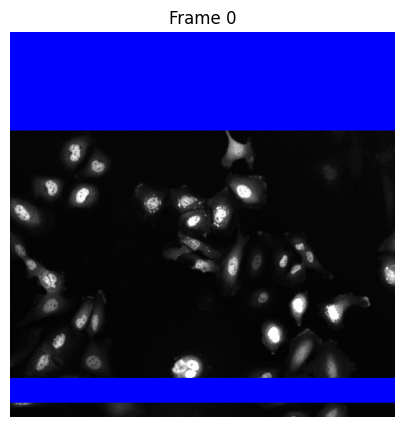

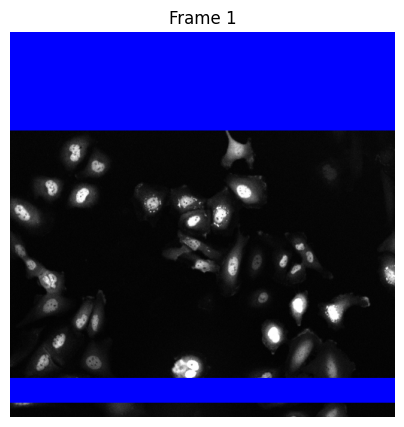

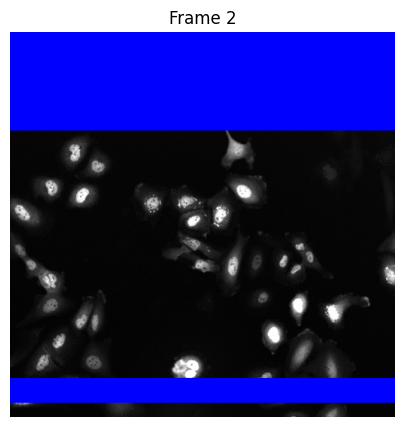

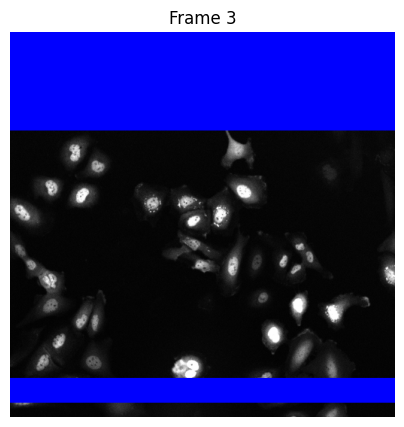

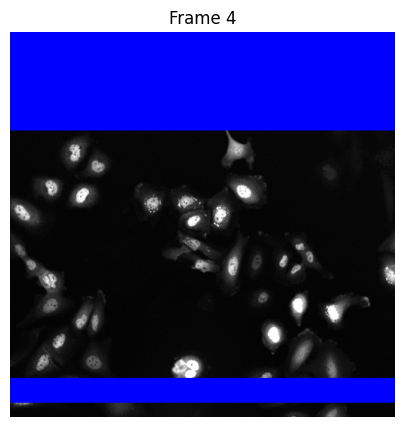

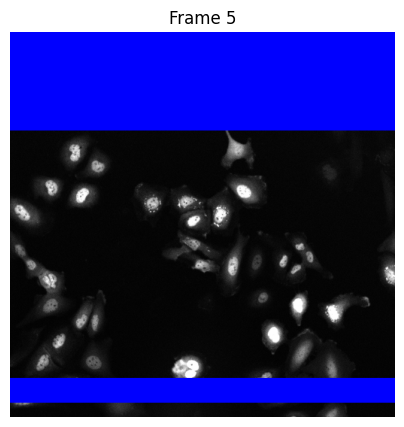

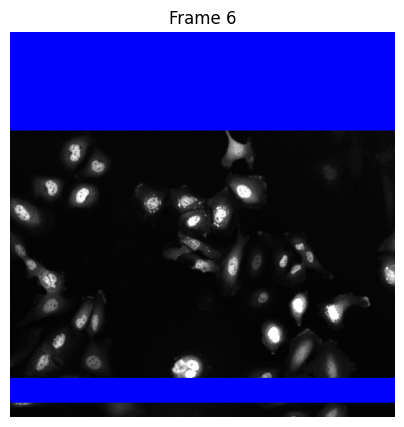

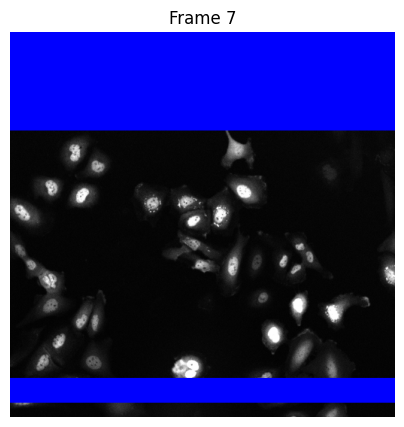

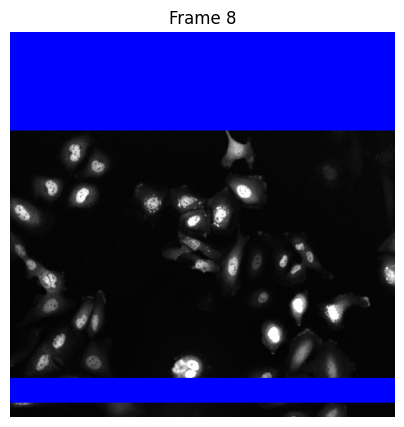

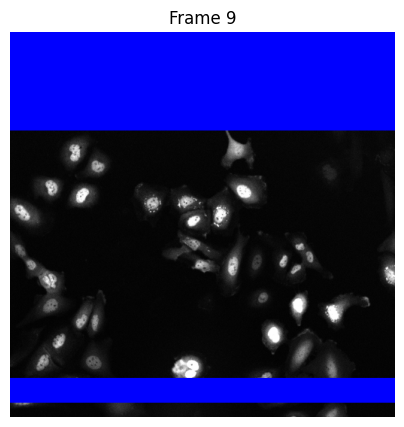

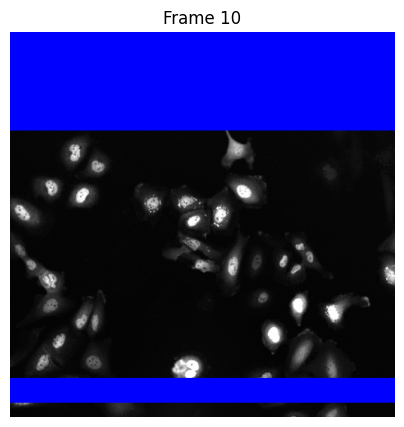

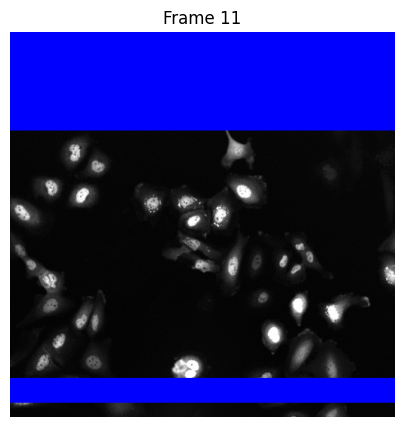

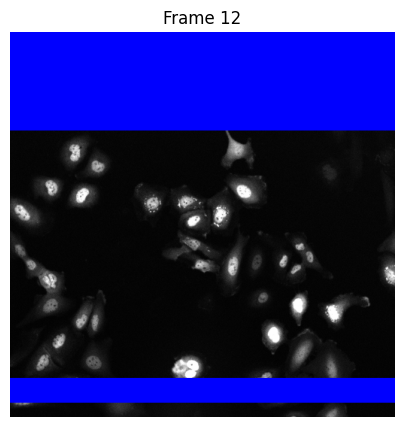

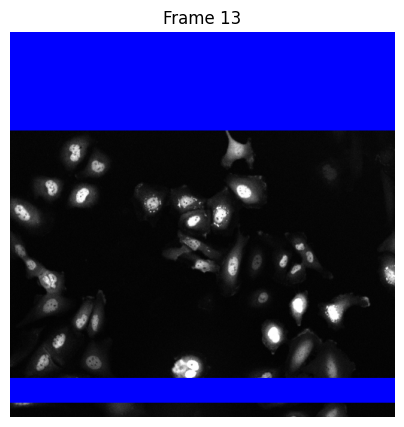

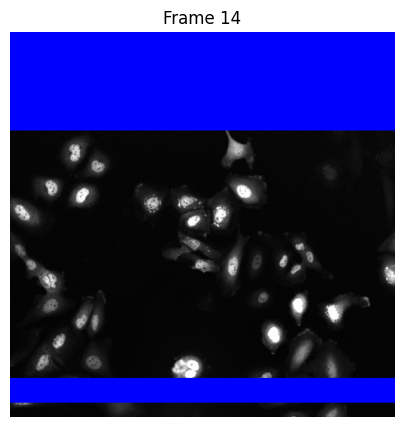

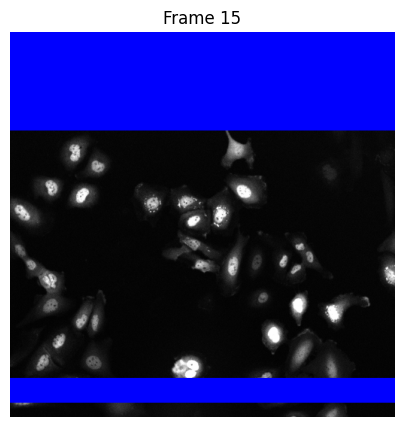

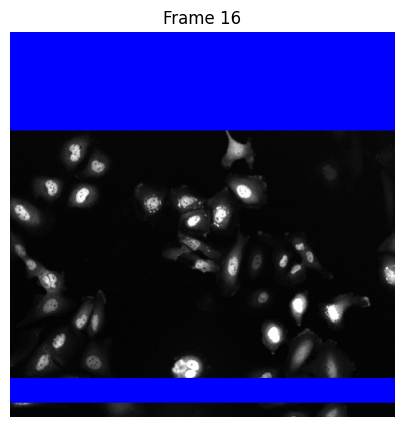

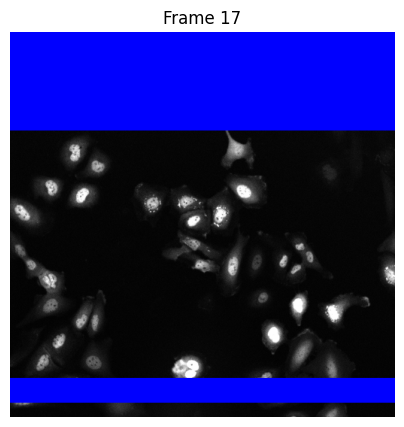

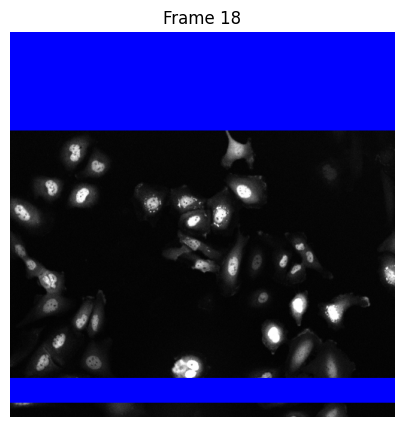

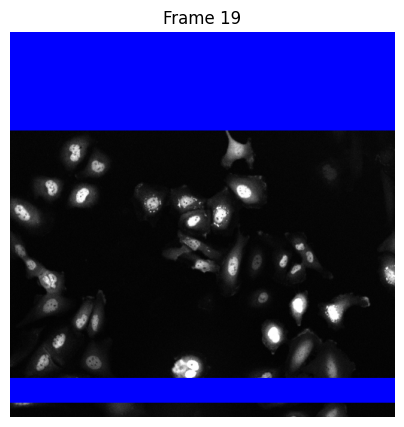

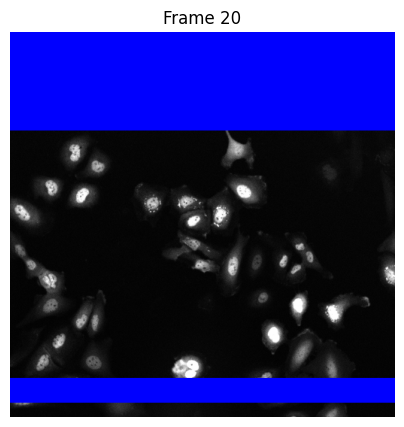

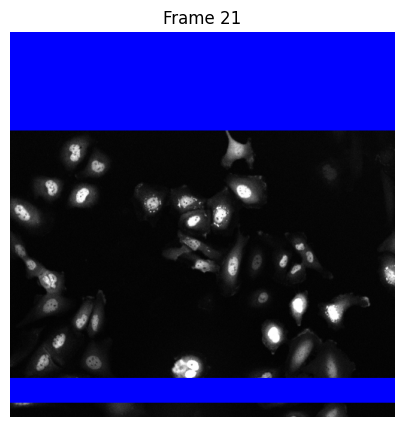

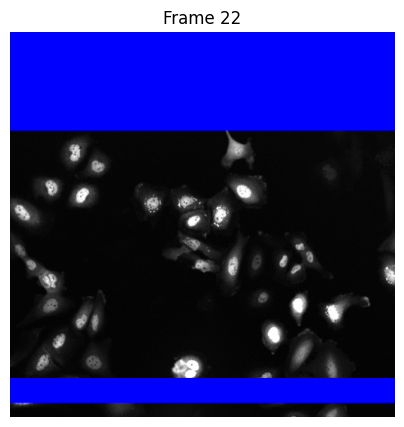

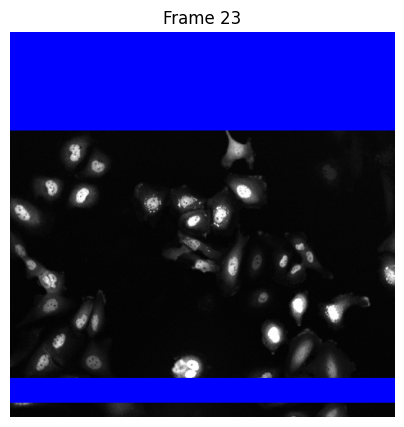

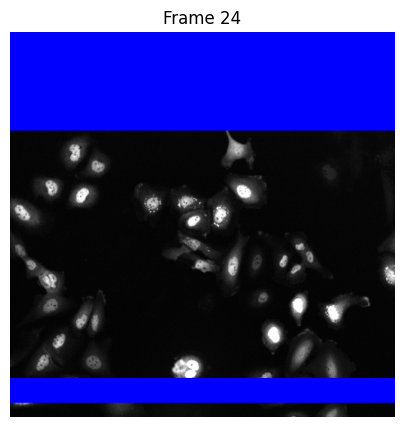

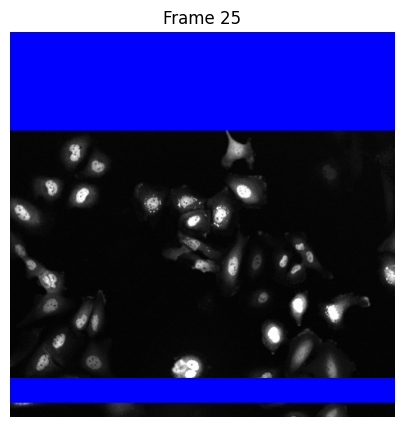

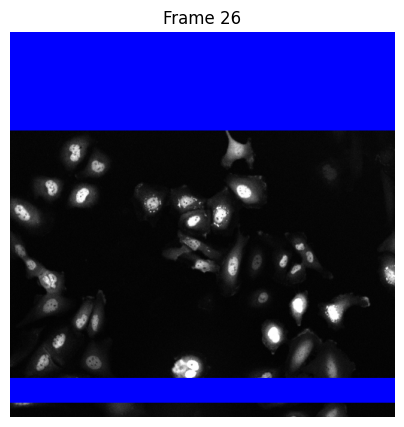

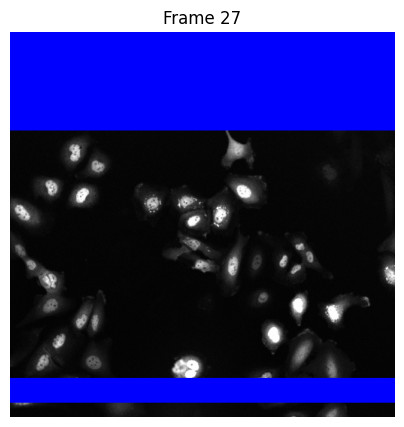

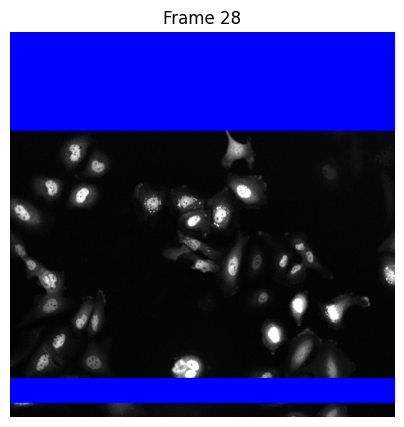

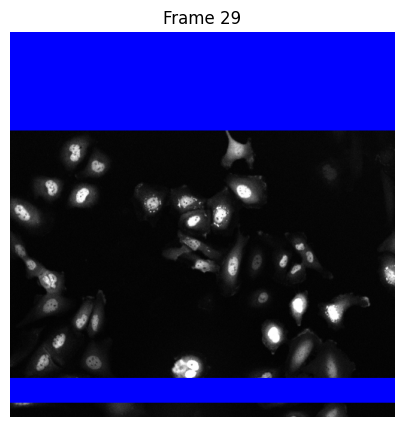

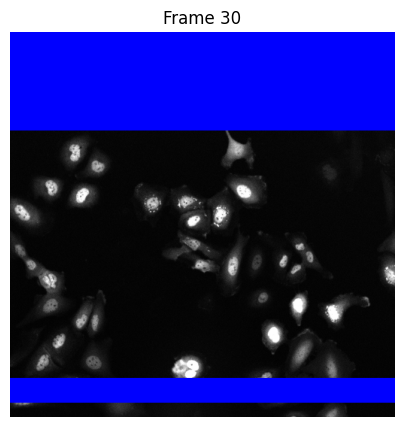

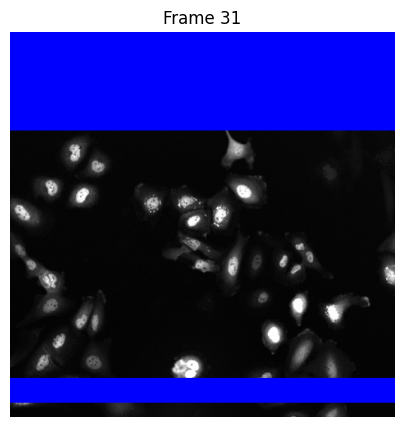

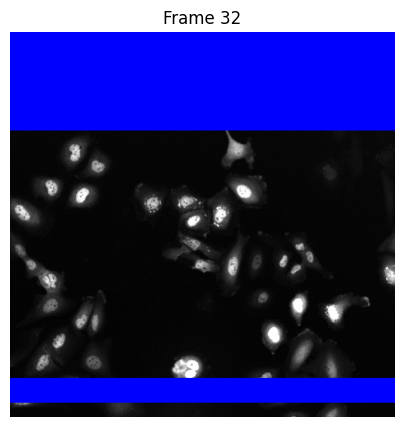

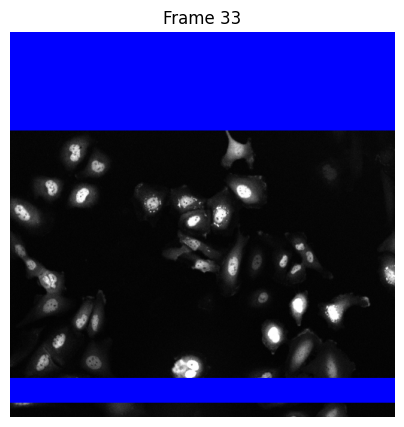

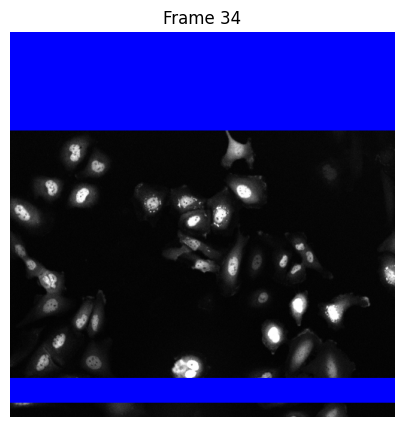

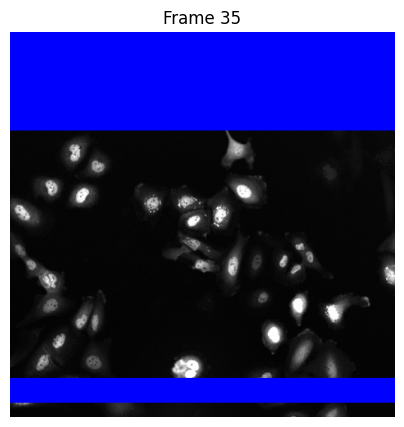

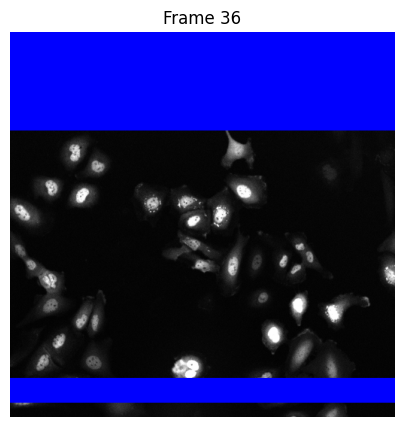

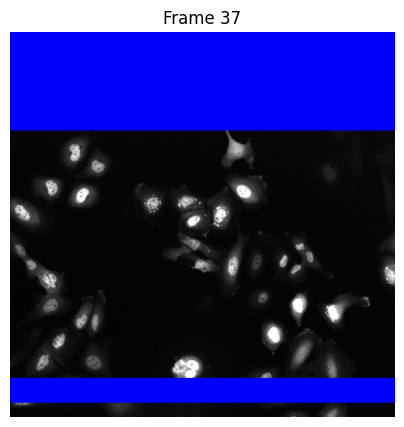

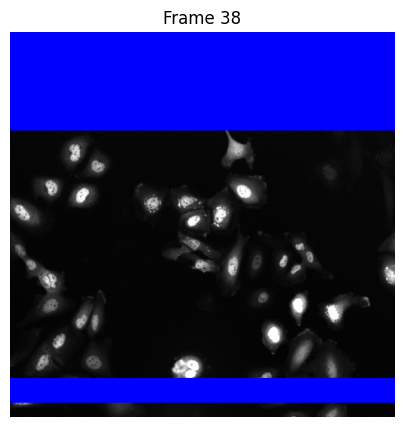

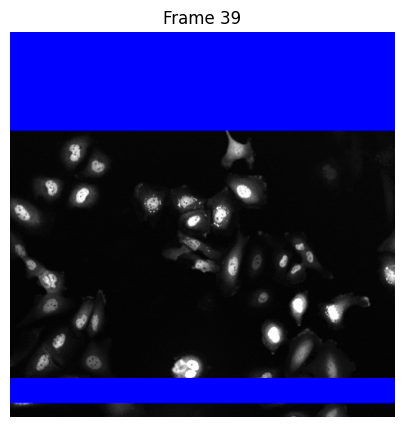

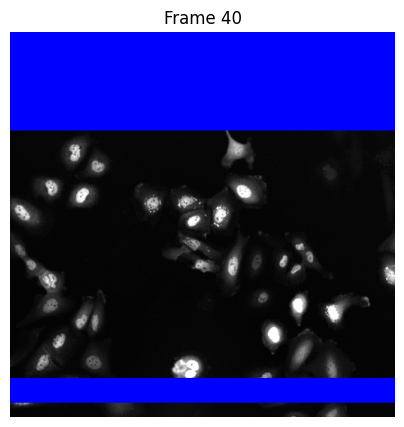

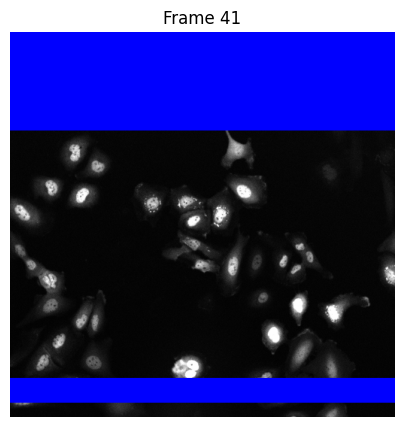

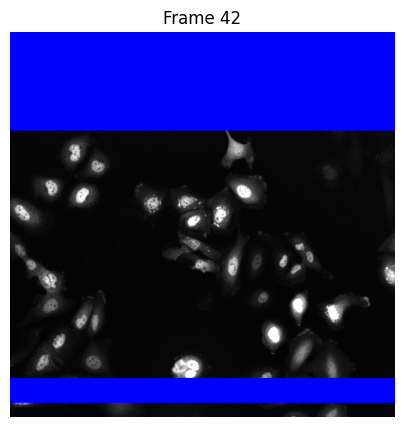

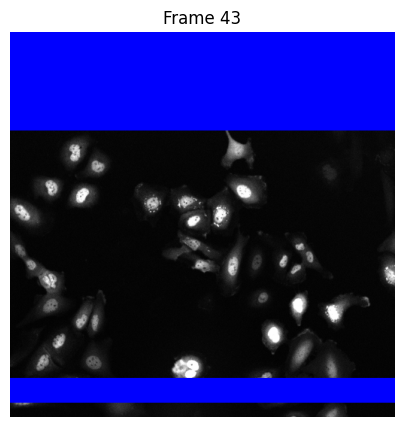

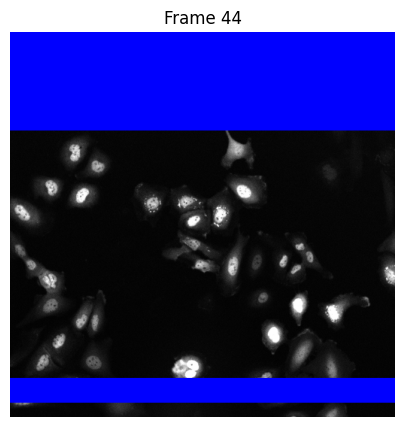

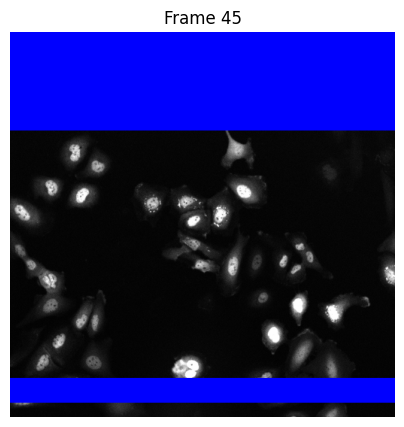

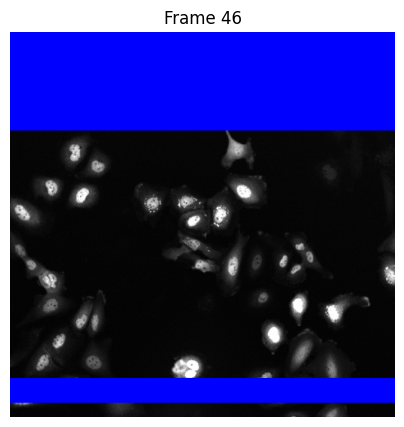

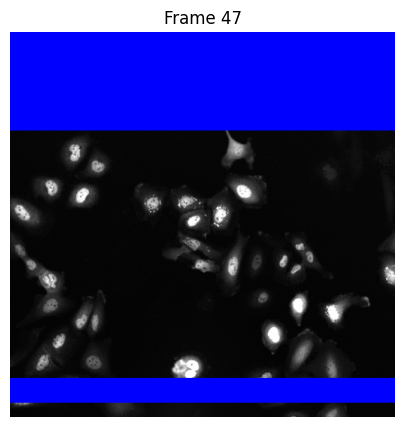

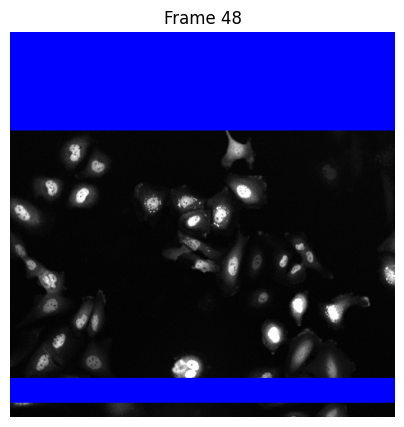

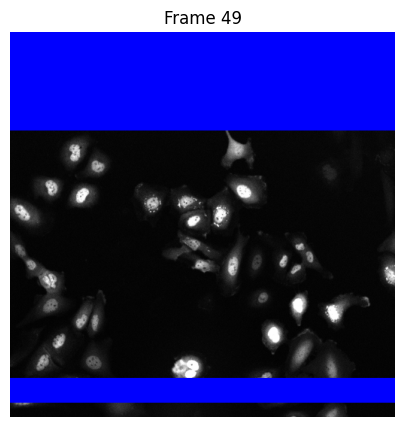

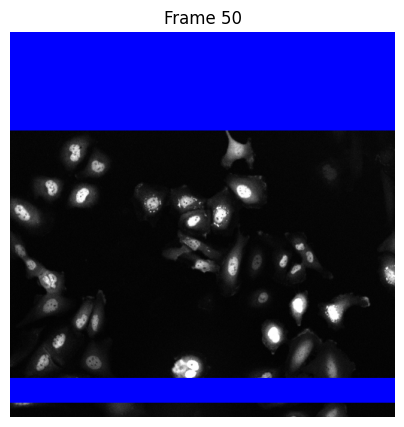

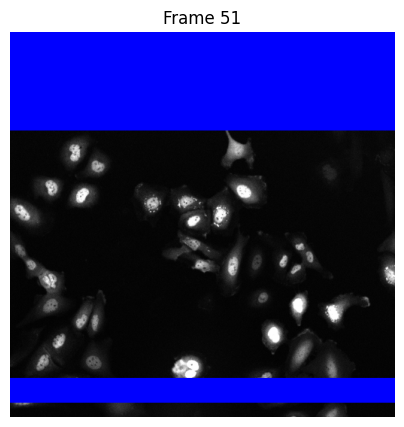

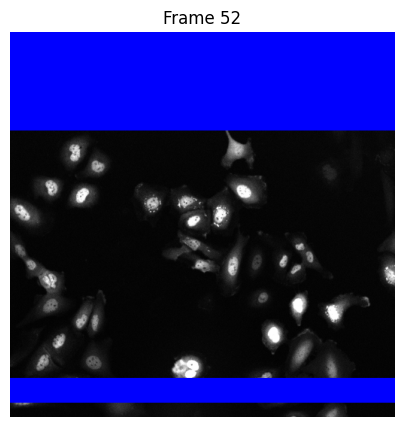

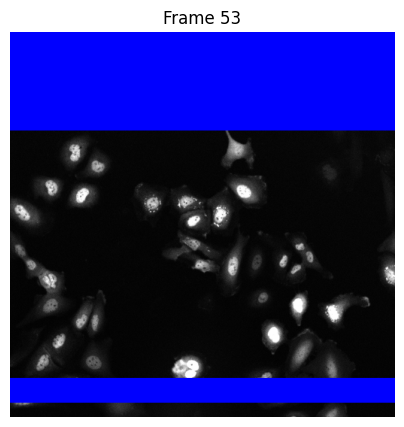

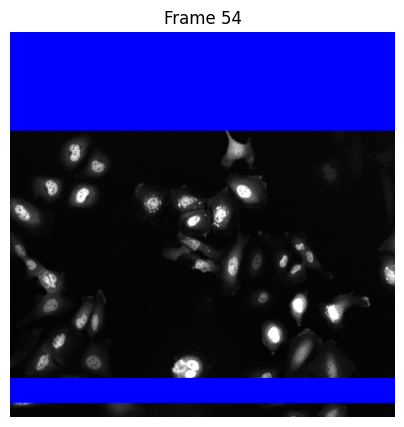

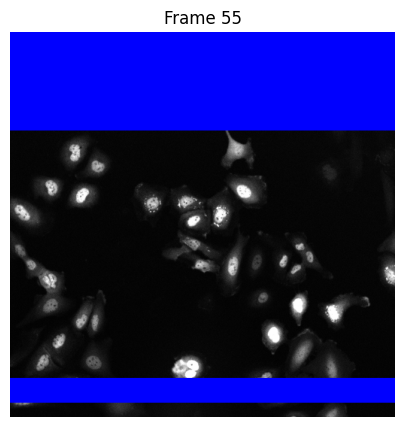

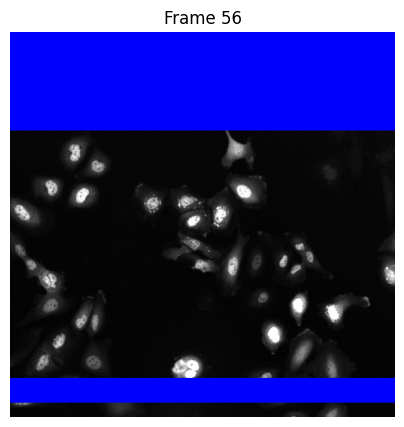

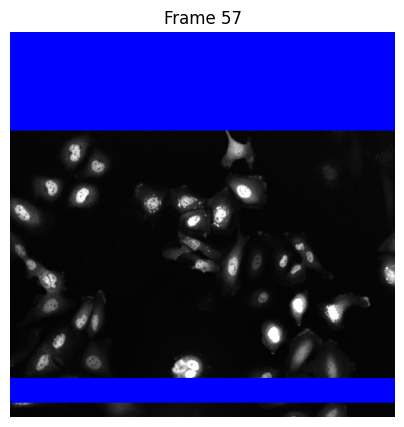

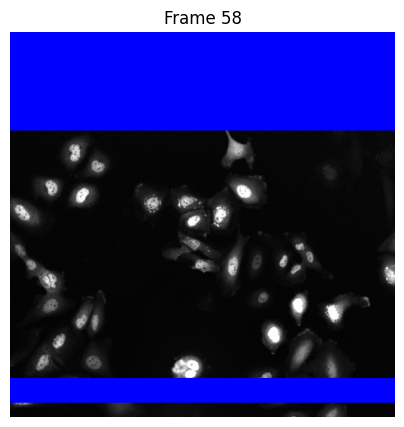

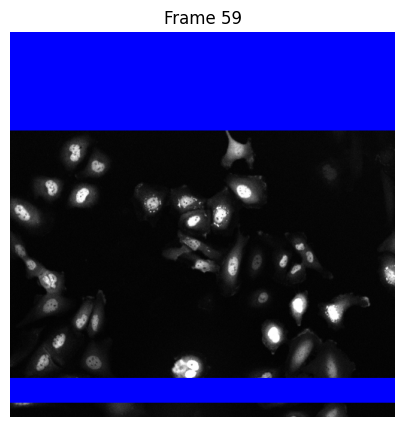

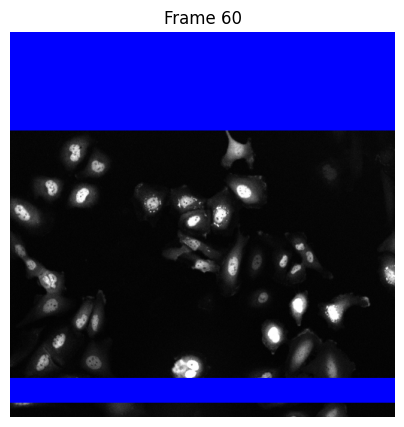

In [43]:
for i, track in enumerate(outputs):
    
    mask_i = mask_outputs[i]
    color = np.array([0, 0, 255])  # rouge BGR
    vis_img[mask_i > 0] = color

    plt.figure(figsize=(5, 5))
    plt.imshow(vis_img) 
    plt.title(f"Frame {i}")
    plt.axis("off")
    plt.show()

In [ ]:
print(mask_outputs[3])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [ ]:
print(vis_img.shape)
print(mask_outputs[3].shape)
mask_2d = mask_outputs[3].reshape((512, 512))


(512, 512, 3)
(512,)


ValueError: cannot reshape array of size 512 into shape (512,512,3)